In [ ]:
import xarray as xr
import numpy as np
from scipy.stats import pearsonr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ds = xr.open_dataset('data/nwp_regrid_197901_202508.nc')
ds = ds.drop_vars('level')
ssta = ds.ssta.fillna(0)
vort = ds.vorticity.fillna(0)

cov_map = xr.cov(ssta, vort, dim='time')
corr_map = xr.corr(ssta, vort, dim='time')

In [ ]:

def corr_pval(x, y):
    # x, y are 1D arrays (time dimension)
    r, p = pearsonr(x, y)
    return r, p

# Apply across lat/lon
corr, pval = xr.apply_ufunc(
    corr_pval,
    ssta, vort,
    input_core_dims=[["time"], ["time"]],
    output_core_dims=[[], []],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float, float]
)


/tmp/ipykernel_170351/3819736485.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(x, y)


In [3]:
sig_corr = corr.where(pval < 0.05)


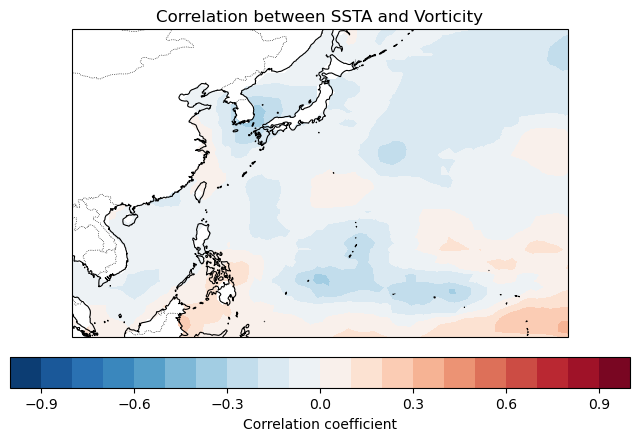

In [ ]:
# Example: plot correlation map
fig, ax = plt.subplots(
    figsize=(8, 5),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Filled contours
cs = ax.contourf(
    corr.lon, corr.lat, corr,  # or cov_map, sig_corr, etc.
    levels=np.linspace(-1, 1, 21),  # adjust for covariance if needed
    cmap='RdBu_r',
    extend='both',
    transform=ccrs.PlateCarree()
)

# Coastlines and features
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')
ax.set_title("Correlation between SSTA and Vorticity")
# Mask correlation where not significant
sig_corr = corr.where(pval < 0.05)

# Plot directly
cs = ax.contourf(
    sig_corr.lon, sig_corr.lat, sig_corr,
    levels=np.linspace(-1, 1, 21),
    cmap='RdBu_r',
    transform=ccrs.PlateCarree()
)
ax.contourf(
    corr.lon, corr.lat, sig_corr,
    levels=[0.5, 1.5], hatches=['', '...'],
    colors='none', transform=ccrs.PlateCarree()
)

# Colorbar
cbar = fig.colorbar(cs, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label("Correlation coefficient")

plt.show()
